In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

import NetModules

%load_ext autoreload

%autoreload 2

In [2]:
T = 1.
N =  1
delta_t = 0.1
X0 = torch.ones(N).view(-1,1)
X = X0

In [3]:
def v(t, x):
    x_bar = torch.mean(x)
    return torch.cos(x_bar) * torch.exp(torch.tensor((T-t)/2))

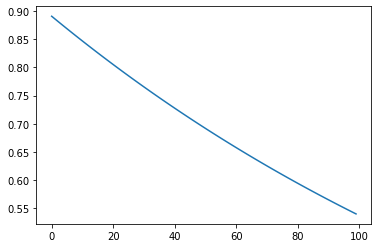

In [4]:
t = np.linspace(0, 1, 100)
plt.plot([v(t_, X) for t_ in t])

In [5]:
def b(i, t, Xt):
    Bi = (t * i / 100 ) * torch.ones((Xt.shape[1], Xt.shape[0]))
    return torch.matmul(Bi, Xt)

In [6]:
def sigma(i, j, t, Xt):
    sigma_ij = (t * i * j / 1000 ) * torch.ones((Xt.shape[1], Xt.shape[0]))
    return torch.matmul(sigma_ij, Xt)

In [7]:
result = torch.zeros((N, int(T/delta_t)))

In [9]:
def simulate_right(X0, d, delta_t=0.1):
    result = torch.zeros((d, int(T/delta_t)))
    for dim in range(d):
        X0 = X0.view(-1)
        X = X0[dim].view(-1,1)
        for i in range(int(T/delta_t)-1):
            Xk = X[-1].view(-1,1)
            t = delta_t * i
            delta_W = torch.normal(torch.zeros(1), delta_t * torch.ones(1))
            X_kp1 = Xk + delta_t * b(1, t, Xk) + v(t, Xk)*delta_W
            X = torch.cat([X, X_kp1])
        result[dim,:] = X.view(-1)
    return result

In [10]:
def simulate_left(X_T, d, delta_t=0.1):
    result = torch.zeros((d, int(T/delta_t)))
    for dim in range(d):
        print(dim)
        X_T = X_T.view(-1)
        X = X_T[dim].view(-1,1)
        for i in reversed(range(int(T/delta_t)-1)):
            Xkp1 = X[-1].view(-1,1)
            t = delta_t * i
            delta_W = torch.normal(torch.zeros(1), delta_t * torch.ones(1))
            X_k = Xkp1 - delta_t * b(1, t, Xkp1) - v(t, Xkp1) * delta_W
            X = torch.cat([X_k, X])
        result[dim,:] = X.view(-1)
    return result

In [11]:
d = 5
Z0 = torch.zeros(d)
Z = simulate_left(Z0, d)

print(Z.shape)

0
1
2
3
4
torch.Size([5, 10])


In [13]:
N = 10
X_T = torch.zeros(N)
X = simulate_left(X_T, N)

Z0 = torch.zeros(N)
Z = simulate_right(Z0, N)

0
1
2
3
4
5
6
7
8
9


0
1


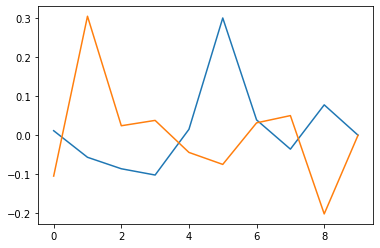

In [14]:
X = simulate_left(X_T, 2)
plt.plot(X[0,:])
plt.plot(X[1,:])

Need to estimate:
- Z
- start with initial U
- Try with a lot of data?

In [17]:
X.shape

torch.Size([2, 10])

In [15]:
def fun(x, y, z, t):
    delta_t = torch.tensor((T - t)/2)
    x_bar = torch.mean(x)
    r1 = (torch.cos(x_bar) + 0.2 * torch.sin(x_bar)) * torch.exp(delta_t)
    r2 = (1/2) * (torch.sin(x_bar) * torch.cos(x_bar) * torch.exp(delta_t)) ** 2
    one = torch.ones(N)
    print("one.shape ", one.shape)
    print("z.shape ", z.shape)
    print("torch.matmul(one, z) ", torch.matmul(one, z))
    r3 = (1/(2*N)) * (y(torch.matmul(one, z).view(-1)))**2

    return r1.view(-1) + r2.view(-1) + r3.view(-1)
    #return torch.tensor(1).view(-1)

In [20]:
X[:, 0].shape

torch.Size([2])

In [21]:
net_vector

DeepSet(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1024, bias=True)
  (psi1): Linear(in_features=1024, out_features=512, bias=True)
  (psi2): Linear(in_features=512, out_features=256, bias=True)
  (psi3): Linear(in_features=256, out_features=1, bias=True)
)

In [30]:
Z[:, 0].shape

torch.Size([10])

In [34]:
N

10

In [36]:
sigma_mat = torch.ones((N, N))

In [37]:
sigma_mat

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [39]:
d = 2
torch.autograd.set_detect_anomaly(True)
criterion = nn.MSELoss()
delta_t = 0.1
EPOCHS = 5
U_ = v(0, torch.ones(N))
for i in range(int(T/delta_t)-1):
    net_vector = NetModules.DeepSet(d).float()
    net_matrix = NetModules.DeepDerSet(N).float()
    optimizer = optim.Adam(net_vector.parameters(), lr=0.01)
    optimizer.add_param_group({'params':net_matrix.parameters()})
    #for X, Z in zip(train_data, test_data):
    print("X[:,i].shape")
    print(X[:,i].shape)
    U = net_vector(X[:,i])

    V = net_matrix(Z[:,i])
    print("V.shape ", V.shape)
    f = fun(X[:,i], net_vector, torch.matmul(sigma_mat, V), i * delta_t)
    delta_W = torch.normal(torch.zeros(1), delta_t * torch.ones(1))
    loss = (U - (U_ + f * delta_t).detach() - V * delta_W.detach())**2
    print("loss : ",loss)

    loss.backward(retain_graph=True)
    optimizer.step()

    net_vector.zero_grad()
    net_matrix.zero_grad()
    U_ = U

X[:,i].shape
torch.Size([2])
10
y.shape
torch.Size([1024])
x.shape
torch.Size([10])
z.shape
torch.Size([1034])
V.shape  torch.Size([10])
one.shape  torch.Size([10])
z.shape  torch.Size([10])
torch.matmul(one, z)  tensor(0.5446, grad_fn=<DotBackward>)


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
batches = 10
net1 = DeepDerSet(N).float()
net2 = DeepSet(N).float()
optimizer = optim.Adam(net.parameters(), lr=0.01) # Corresponds to evything that is adjustable
criterion = nn.MSELoss()
EPOCHS = 100
outputs_epoch = []

losses_epoch = []
for epoch in range(EPOCHS):
    loss_batch = []
    for i in range(batches):
        net.zero_grad()
        k = int(n_data /batches)
        dataX = X[i:i+k,:]
        dataY = synth[i:i+k,:]
        tot_loss = 0
        net.zero_grad()
        for j , (x, Y) in enumerate(zip(dataX, dataY)):
            output = net(X)
            loss = criterion(output, Y)
            tot_loss += loss
            loss_batch.append(loss)
        tot_loss.backward() # Backpropagate the loss
        optimizer.step() # Adjusts the steps
    losses_epoch.append(loss_batch)
    print('LOSS = ', tot_loss)
    if test_convergence(losses_epoch, 0.5):
        break